# Notebook to Analyze the Efficacy of Generative Models for Anomaly Detection

In this notebook we will look to use different generative models on graphs to learn distributions over normal graphs and hopefully detect some anomalies. We specifically start our experimentation looking at the GraphRNN framework implemented by the SNAP group

In [1]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
%matplotlib inline

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# All necessary arguments are defined in args.py
args = Args()
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.cuda)
print('CUDA', args.cuda)
print ('CUDA Available:', torch.cuda.is_available())

CUDA 1
CUDA Available: True


In [27]:
# Set the type of graph that we want to evaluate the log likelihoods of
args.change_dataset("enzymes_small")

In [28]:
# Load the graph data - Consider using presaved datasets! with graph load list
graphs = create_graphs.create(args)

# Save this for later testing of different datasets to allow for 
# compatability
max_prev_node = args.max_prev_node

# split datasets
random.seed(123)
shuffle(graphs)
graphs_len = len(graphs)
graphs_test = graphs[int(0.8 * graphs_len):]
graphs_train = graphs[0:int(0.8*graphs_len)]
graphs_validate = graphs[0:int(0.2*graphs_len)]

Loading graph dataset: ENZYMES
Loaded


In [29]:
# Display some graph stats
graph_validate_len = 0
for graph in graphs_validate:
    graph_validate_len += graph.number_of_nodes()
graph_validate_len /= len(graphs_validate)
print('graph_validate_len', graph_validate_len)

graph_test_len = 0
for graph in graphs_test:
    graph_test_len += graph.number_of_nodes()
graph_test_len /= len(graphs_test)
print('graph_test_len', graph_test_len)


args.max_num_node = max([graphs[i].number_of_nodes() for i in range(len(graphs))])
max_num_edge = max([graphs[i].number_of_edges() for i in range(len(graphs))])
min_num_edge = min([graphs[i].number_of_edges() for i in range(len(graphs))])

# show graphs statistics
print('total graph num: {}, training set: {}'.format(len(graphs),len(graphs_train)))
print('max number node: {}'.format(args.max_num_node))
print('max/min number edge: {}; {}'.format(max_num_edge,min_num_edge))
print('max previous node: {}'.format(args.max_prev_node))

graph_validate_len 15.666666666666666
graph_test_len 15.136363636363637
total graph num: 109, training set: 87
max number node: 20
max/min number edge: 49; 17
max previous node: 15


In [30]:
# Initialize the dataset and dataloader for analyzing the nlls. 
# Note that we use batch_size = 1 because we want the nll for each
# data point not an average across a batch.
# We should also consider using Graph_sequence_Sampler_pytorch_nll.
# This sampler expands the size of the dataset by for each graph 
# creating many different bfs permutations. The idea behind this sampler
# is to test the models permutation invariance. 

train_dataset = Graph_sequence_sampler_pytorch_rand(graphs_train,max_prev_node=args.max_prev_node,max_num_node=args.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(graphs_test, max_prev_node=args.max_prev_node,max_num_node=args.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args.num_workers)



In [20]:
# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args.max_prev_node, embedding_size=args.embedding_size_rnn,
                        hidden_size=args.hidden_size_rnn, num_layers=args.num_layers, has_input=True,
                        has_output=True, output_size=args.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args.embedding_size_rnn_output,
                        hidden_size=args.hidden_size_rnn_output, num_layers=args.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)

In [43]:
# This function encapsulates the process of getting the loglikelihoods
# of the data
def calc_nll(args, data_loader, rnn, output, max_iter=100, load_epoch=3000, train_dataset=None):
    """
        For now the max_iter is not used. However, the idea in the future
        is to do max_iter loops of calculating the nlls of the data. Since
        the model is permutation dependent, namely we use a random bfs ordering
        for each graph when training/testing, we should do many iterations to
        test the robustness of the model to permutation. This could also be
        addressed using nll data_loader. 
    """
    # Set the epoch we are loading from
    args.load_epoch = load_epoch
    if train_dataset:
        fname = args.note + '_' + train_dataset + '_' + str(args.num_layers) + '_' + str(args.hidden_size_rnn) + '_'
        
        fname_rnn = args.model_save_path + fname + 'lstm_' + str(args.load_epoch) + '.dat'
        fname_out = args.model_save_path + fname + 'output_' + str(args.load_epoch) + '.dat'
    else:
        fname_rnn = args.model_save_path + args.fname + 'lstm_' + str(args.load_epoch) + '.dat'
        fname_out = args.model_save_path + args.fname + 'output_' + str(args.load_epoch) + '.dat'
    
    rnn.load_state_dict(torch.load(fname_rnn))
    output.load_state_dict(torch.load(fname_out))

    epoch = args.load_epoch
    print('model loaded!, epoch: {}'.format(args.load_epoch))

    # Calculate nll over dataset max_iter times,
    # to test robustness to permutations of the bfs
    # ordered adjacency matrix for the same graphs.
    nlls = []
    for i in range(max_iter):
        nll = rnn_data_nll(args, rnn, output, data_loader)
        # Logging info
        # May want to also include std statistics
        if (i + 1) % 10 == 0:
            print ("Iteration:", i + 1)
            print ("Average Nll:", np.mean(nll))
            
        nlls.extend(nll)
        
    return nlls

model loaded!, epoch: 3000
Iteration: 10
Average Nll: 26.69428232346458
Iteration: 20
Average Nll: 27.047120258725922
Iteration: 30
Average Nll: 25.205868929282
Iteration: 40
Average Nll: 25.27977887515364
Iteration: 50
Average Nll: 25.905436362343274
Iteration: 60
Average Nll: 26.9986080301219
Iteration: 70
Average Nll: 25.669270778524464
Iteration: 80
Average Nll: 25.272927196546533
Iteration: 90
Average Nll: 25.658811032086952
Iteration: 100
Average Nll: 25.15561975281814


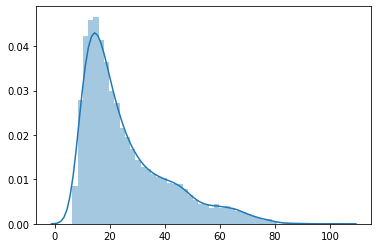

In [8]:
# Let's do some analysis on the training data
nlls = calc_nll(args, train_loader, rnn, output)
plt.figure()
sns.distplot(nlls, kde=True)
#plt.xlim([0, 55])

model loaded!, epoch: 3000
Iteration: 10
Average Nll: 44.381026614796035
Iteration: 20
Average Nll: 44.37866774472323
Iteration: 30
Average Nll: 41.15060147372159
Iteration: 40
Average Nll: 46.09560658714988
Iteration: 50
Average Nll: 39.58878378434615
Iteration: 60
Average Nll: 45.46509122848511
Iteration: 70
Average Nll: 41.3623384995894
Iteration: 80
Average Nll: 43.30077492107045
Iteration: 90
Average Nll: 44.150635805996984
Iteration: 100
Average Nll: 38.753051324324176


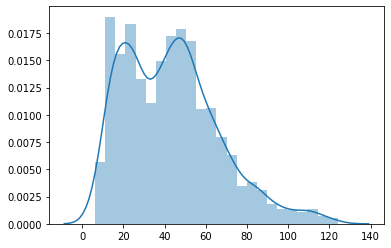

In [9]:
# Analysis of the test data set nlls.
nlls = calc_nll(args, test_loader, rnn, output)
plt.figure()
sns.distplot(nlls, kde=True)

In [31]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_ladder = Args()
args_ladder.change_dataset("ladder_small")

In [37]:
# Load the graph data - Consider using presaved datasets! with graph load list
graphs_ladder = create_graphs.create(args_ladder)

# We don't need to split the dataset. We just want to test it
random.seed(123)
shuffle(graphs_ladder)
graphs_len = len(graphs_ladder)

# Display some graph stats
graph_node_avg = 0
for graph in graphs_ladder:
    graph_node_avg += graph.number_of_nodes()
graph_node_avg /= graphs_len
print('Average num nodes', graph_node_avg)

args_ladder.max_num_node = max([graphs_ladder[i].number_of_nodes() for i in range(graphs_len)])
max_num_edge = max([graphs_ladder[i].number_of_edges() for i in range(graphs_len)])
min_num_edge = min([graphs_ladder[i].number_of_edges() for i in range(graphs_len)])

# show graphs statistics
print('total graph num: {}'.format(graphs_len))
print('max number node: {}'.format(args_ladder.max_num_node))
print('max/min number edge: {}; {}'.format(max_num_edge,min_num_edge))
print('max previous node: {}'.format(args_ladder.max_prev_node))

Average num nodes 12.0
total graph num: 9
max number node: 20
max/min number edge: 28; 4
max previous node: 10


In [38]:
# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder,max_prev_node=max_prev_node,max_num_node=args_ladder.max_num_node)
ladder_loader = torch.utils.data.DataLoader(ladder_dataset, batch_size=1, num_workers=args_ladder.num_workers)


model loaded!, epoch: 3000
Iteration: 10
Average Nll: 85.87466091579861
Iteration: 20
Average Nll: 77.99962425231934
Iteration: 30
Average Nll: 76.96146604749892
Iteration: 40
Average Nll: 80.17995240953233
Iteration: 50
Average Nll: 83.64858542548285
Iteration: 60
Average Nll: 86.85916731092665
Iteration: 70
Average Nll: 81.2029488881429
Iteration: 80
Average Nll: 88.22650994194879
Iteration: 90
Average Nll: 75.60993745591905
Iteration: 100
Average Nll: 76.05505794949002


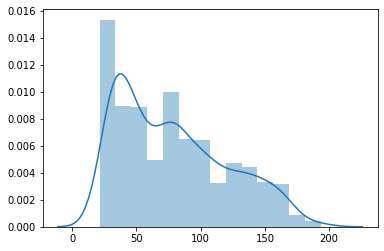

In [34]:
# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes
nlls = calc_nll(args_ladder, ladder_loader, rnn, output, train_dataset="enzymes_small")
plt.figure()
sns.distplot(nlls, kde=True)

In [39]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_caveman = Args()
args_caveman.change_dataset("caveman_small")

In [41]:
# Load the graph data - Consider using presaved datasets! with graph load list
graphs_caveman = create_graphs.create(args_caveman)

# We don't need to split the dataset. We just want to test it
random.seed(123)
shuffle(graphs_caveman)
graphs_len = len(graphs_caveman)

# Display some graph stats
graph_node_avg = 0
for graph in graphs_caveman:
    graph_node_avg += graph.number_of_nodes()
graph_node_avg /= graphs_len
print('Average num nodes', graph_node_avg)

args_caveman.max_num_node = max([graphs_caveman[i].number_of_nodes() for i in range(graphs_len)])
max_num_edge = max([graphs_caveman[i].number_of_edges() for i in range(graphs_len)])
min_num_edge = min([graphs_caveman[i].number_of_edges() for i in range(graphs_len)])

# show graphs statistics
print('total graph num: {}'.format(graphs_len))
print('max number node: {}'.format(args_caveman.max_num_node))
print('max/min number edge: {}; {}'.format(max_num_edge,min_num_edge))
print('max previous node: {}'.format(args_caveman.max_prev_node))

Average num nodes 16.0
total graph num: 100
max number node: 20
max/min number edge: 78; 21
max previous node: 20


In [42]:
# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
caveman_dataset = Graph_sequence_sampler_pytorch_rand(graphs_caveman,max_prev_node=max_prev_node,max_num_node=args_caveman.max_num_node)
caveman_loader = torch.utils.data.DataLoader(caveman_dataset, batch_size=1, num_workers=args_caveman.num_workers)


model loaded!, epoch: 3000
Iteration: 10
Average Nll: 111.67992435455322
Iteration: 20
Average Nll: 118.95924066543579
Iteration: 30
Average Nll: 115.25308937072754
Iteration: 40
Average Nll: 116.73195655822754
Iteration: 50
Average Nll: 113.55894592285156
Iteration: 60
Average Nll: 116.2225887298584
Iteration: 70
Average Nll: 114.66553560256958
Iteration: 80
Average Nll: 117.23784170150756
Iteration: 90
Average Nll: 115.97136255264282
Iteration: 100
Average Nll: 116.40289325714112


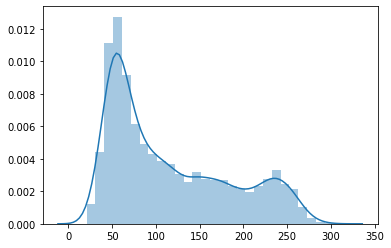

In [44]:
# Let's see how the nlls of the caveman graphs compare to 
# the trained on enzymes
nlls = calc_nll(args_caveman, caveman_loader, rnn, output, train_dataset="enzymes_small")
plt.figure()
sns.distplot(nlls, kde=True)